This notebook can be used for making and visualizing the images of the XYZeq datasets. You can choose which stats and which color channels to map to which values of the sequencing data.

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt

import warnings
from tqdm.notebook import tqdm
import itertools as it
import pickle as pkl
import os

## 1. Read in Adata and Spatial Barcodes

In [2]:
prefix = '/data/xyzeq/xyzeq/'

In [3]:
adata = sc.read_h5ad(prefix + 'concatenated.deep/deep2/concat.deep.adata.m.and.h.combatted.dimred.subsetted.dimred.h5ad')

In [4]:
spatial = pd.read_csv(prefix + 'plate23_map.csv', header=None, index_col=0)
spatial.columns = ['X','Y']

In [5]:
spatial

,X,Y
0,,
AGTTGTTCTAGCGCCT,1,1
CCGTTAGACGTGACAG,1,2
CTTACGGTCCGTACGT,1,3
TCCTGCATTGTGAGAA,1,4
CTGCGCACTGCTTCTT,1,5
...,...,...
CCTGTTGTATGGTTAC,44,2
TCAATCTATGAGTCGC,44,3
TCGCGACTGCCACTAC,44,4


In [6]:
spatial.iloc[-20:,:]

,X,Y
0,,
CGCACTATAGGTTAAG,42,11
ATCGCGGTTCCTGAGG,42,12
AGTAGAGTTATCGTCC,42,13
GCTTGACCGTAATCGA,42,14
CGGCTCATTACTGCGG,42,15
GGACGCCTACAATGAT,42,16
TACATCGACGAACCTG,42,17
AGCGGAGAGTCAAGCT,42,18
GCATCCAATCGCGTTA,43,1


X indices 43 and 44 don't have a full set of Y indices. These indices are on the edge of the array and are complicating some of the operations further downstream. Because I've examined some of the outputs and they do not seem to be terribly useful anyway (probably contain very few cells), I'm going to drop them for now. I will do this after I add the columns to the `adata.obs`.

In [7]:
adata.obs['spatial_bc'] = [i.split('.')[1].split('-')[0] for i in adata.obs_names]

In [8]:
adata.obs['X'] = list(map(lambda x: spatial.loc[x,'X'], adata.obs['spatial_bc']))
adata.obs['Y'] = list(map(lambda x: spatial.loc[x,'Y'], adata.obs['spatial_bc']))

In [9]:
sum(adata.obs['X'] > 42)

26

Only 26 cells across 5 batches in these wells. Let's just drop them.

In [10]:
adata = adata[adata.obs['X'] <= 42].copy()

I'm also only going to use the first 4 batches, since the last batch was actually from the same exact slice (and I've confirmed after examining outputs that they are almost identical). We could possibly merge them into one output (now more cells for the combined batch) but not sure if that'd be explainable, since we technically tried to enrich for CD8s and it just didn't work.

In [11]:
adata = adata[adata.obs['batch'] != '4'].copy()

## 2. Build the HexMap
Instead of relying on matplotlib, for many reasons I've decided to just build the image manually using a numpy array.

When considering the hexagons:
1. We want something as small as possible because for super resolution we will be registering to _pixel_ resolution. 
2. We need something that stacks. I don't know the theory or jargon around this, but I've determined (mostly through trial and error) we need something with an even number of pixels per side to prevent single-pixel points on the sides, as those don't stack.

I've come to the conclusion that the smallest, most-hexagon-like figure we can generate is the one that fits inside a 12 x 12 pixel grid.

In [12]:
myhex = np.zeros((12,12)) 

In [13]:
myhex[0:1,3:9] = 1
myhex[1:3,2:10] = 1
myhex[3:5,1:11] = 1
myhex[5:7,:12] = 1
myhex[7:9,1:11] = 1
myhex[9:11,2:10] = 1
myhex[11:12,3:9] = 1

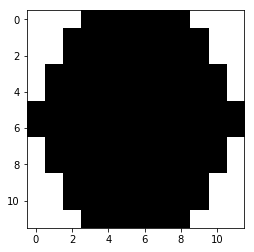

In [14]:
plt.imshow(myhex, cmap='binary');

Our hexagon has 6 pixel-long sides on top and bottom. If it were a true hexagon, the pixels on the vertical sides would also be 6 units long. We can try to measure one by using the length of the right triangle formed from the 3 pixels jutting out and 6 pixels high, which ends up creating a hypotenuse vertical side of theortical 6.71 units long, so 6 ~ 6.7, I'd say is close enough (~10% off) to true hexagon. The 12-pixel-long hexagon also has the added benefit of spatial resolution to around the diameter of a cell (500/12 is 40 um, roughly the size of what I'd imagine are the largest cells we'll be picking up). 

Now building the array of hexagons. I will mark the location of key points of each hexagons in a lookup dataframe called `hex_coords` so I don't have to build it everytime I need to fill in new values.

In [309]:
# make a lookup table, so that I don't have to do all these calculations again
hex_coords = pd.DataFrame(0,index=pd.MultiIndex.from_product([range(1,43), range(1,19)], names=['X','Y']),
                          columns=['hex_xstart','hex_ystart', 'center_xstart', 'center_ystart', 'hex_xend', 'hex_yend'])

for y, x in it.product(range(1,19),range(1,43)):
    xstart = int(6*(x-1)*1.5) # please don't ask me how I figured this equation out, it works
    ystart = (y-1)*12
    if x % 2 == 0:  
        ystart = ystart + 6

    # make a lookup table, so that I don't have to do all these calculations again
    hex_coords.loc[(x,y),'hex_xstart'] = xstart
    hex_coords.loc[(x,y),'hex_ystart'] = ystart
    hex_coords.loc[(x,y),'center_xstart'] = xstart + 5
    hex_coords.loc[(x,y),'center_ystart'] = ystart + 5
    hex_coords.loc[(x,y),'hex_xend'] = xstart + 12
    hex_coords.loc[(x,y),'hex_yend'] = ystart + 12
# hex_coords = hex_coords.astype(np.uint8) # definitely don't convert to integers, it will mess things up, not quite sure how exactly at the current moment

Now fill in the hex array with random colors to show it works.

In [310]:
img = list()
for color in ['r','g','b']:
    hex_array = np.zeros((222,381)) # these are calculated to perfectly encapsulate the 19 x 43 well array
    for y, x in it.product(range(1,19),range(1,43)):
        
        val = np.random.choice(range(50,255))
        
        xstart = hex_coords.loc[(x,y),'hex_xstart']
        ystart = hex_coords.loc[(x,y),'hex_ystart']

        yend = hex_coords.loc[(x,y),'hex_yend']
        xend = hex_coords.loc[(x,y),'hex_xend']
        
        current_hex = hex_array[ystart:yend,xstart:xend]
        hex_array[ystart:yend,xstart:xend] = np.where(myhex, val, current_hex)
    img.append(hex_array)
img = np.stack(img, axis=2).astype(np.uint8)

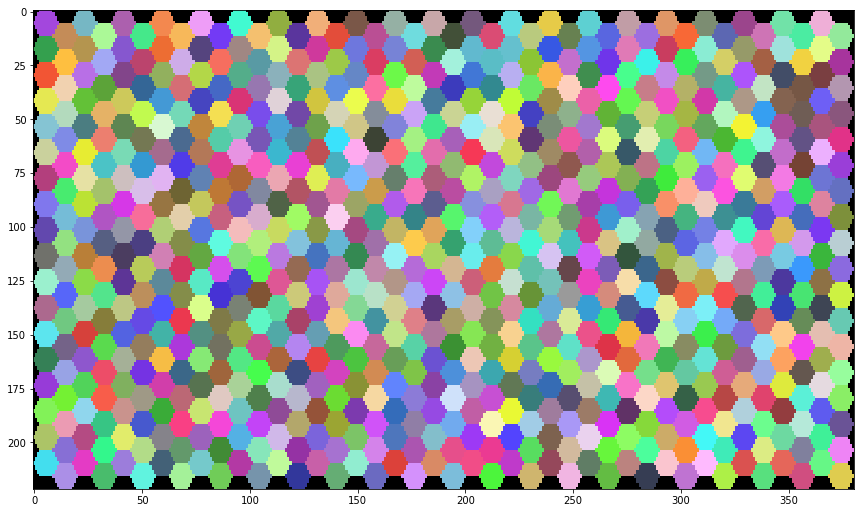

In [311]:
plt.figure(figsize=(400/25,220/25)) # chose this size to keep the aspect ratio
plt.imshow(img, cmap='binary');

I would also like to make a list of neighbors for each well for use later. Neighbors are divided into layers of proximity, where the layer corresponds to the least number of jumps from one well to the neighbor, which I imagine this perfectly correlates with, or at least very well approximates, true physical distance of a cell in one well to another given our resolution. 

So I wrote a function to get immediate neighbors which works well. However, if we think about it, neighbors of well _(x, y)_ of layer _L_ = 2 are just the **_new_** neighbors of those wells of _L_ = 1. This can be formalized with better and notation, but in essence we just need to iteratively get the immediate neighbors of our neighbors to get those layers that are more than 1 away. Because I calculate immediate neighbors once and store it in the `hex_coords` Dataframe, I don't need to iteratively call the function but rather just look up the neighbors.

Very proud of the two cells below, although this *might* have been easier with just applying a function that could probably do this for perfectly orthogonal coordinates and then just shifting every other row up or down by one.

In [312]:
def immediate_neighbors(x, y):
    if x % 2 == 0:
        neighbors = np.array([(x-1, y+1), (x, y+1), (x+1, y+1), (x-1, y), (x+1, y), (x, y-1)])
    else:
        neighbors = np.array([(x-1, y-1), (x, y-1), (x+1, y-1), (x-1, y), (x+1, y), (x, y+1)])
    
    neighbors = np.array([i for i in neighbors if not np.any(i <= 0)
                     and not np.any(i[0] > 42) 
                     and not np.any(i[1] > 18)]) # remove those that are outside array bounds
    neighbors = set(tuple(i) for i in neighbors) # convert to set for easier manipulation alter
    return neighbors

In [313]:
for layer in range(1,11):
    if layer == 1:
        # exclude has one key for each well, and value = set() of wells to exclude when trying to determine the newest layer of neighbors
        # for each layer, value set() grows by set of wells that have already been included in a neighbor set + the center well in question
        # tried to make `exclude` a col in the df, but pands was giving me trouble for setting a value of df to a set()
        exclude = dict() 
        
        # a list of neighbors that will become the column in the df
        neighbors_list = list()
        for x, y in tqdm(it.product(range(1,43), range(1,19)),total=42*18):
            neighbors = immediate_neighbors(x, y) # get the immediate neighbors
            neighbors_list.append(neighbors) # add them to the list of neighbors
            exclude[(x,y)] = neighbors.union(set([(x,y)])) # add the well in question
    else:
        neighbors_list = list() 
        
        for x, y in tqdm(it.product(range(1,43), range(1,19)),total=42*18):
            neighbors_2 = set() # neighbors "squared", i.e. the neighbors of the neighbors in question
            
            for neighbor in hex_coords.loc[(x, y), 'neighbors_%s' % (layer-1)]: # for each neighbor...,
                neighbors_2 = neighbors_2.union(hex_coords.loc[neighbor,'neighbors_1']) # ..., get its immediate neighbors
                
            new_neighbors = neighbors_2.difference(exclude[(x,y)]) # exclude the neighbors that are already in a neighbors list
            exclude[(x,y)] = exclude[(x,y)].union(new_neighbors) # update the exclude set() with the new neighbors
            neighbors_list.append(new_neighbors)
    hex_coords['neighbors_%s' % layer] = neighbors_list # put the neighbors list in the df

In [314]:
hex_coords.head()

hex_xstart  hex_ystart  center_xstart  center_ystart  hex_xend  hex_yend  \
X Y                                                                             
1 1           0           0              5              5        12        12   
  2           0          12              5             17        12        24   
  3           0          24              5             29        12        36   
  4           0          36              5             41        12        48   
  5           0          48              5             53        12        60   

                          neighbors_1  \
X Y                                     
1 1                  {(1, 2), (2, 1)}   
  2  {(1, 3), (1, 1), (2, 1), (2, 2)}   
  3  {(1, 2), (2, 3), (1, 4), (2, 2)}   
  4  {(1, 5), (1, 3), (2, 3), (2, 4)}   
  5  {(2, 5), (1, 6), (2, 4), (1, 4)}   

                                           neighbors_2  \
X Y                                                      
1 1                   {(3, 2), (1, 3), (3, 1), (2, 2)}   
  2           {(3, 2), (3, 3), (3, 1), (1, 4), (2, 3)}   
  3  {(3, 2), (3, 3), (2, 1), (1, 5), (1, 1), (3, 4...   
  4  {(1, 2), (3, 3), (1, 6), (2, 2), (2, 5), (3, 4...   
  5  {(1, 3), (2, 6), (2, 3), (3, 6), (1, 7), (3, 4...   

                                           neighbors_3  \
X Y                                                      
1 1           {(3, 3), (1, 4), (2, 3), (4, 2), (4, 1)}   
  2   {(1, 5), (4, 3), (3, 4), (4, 2), (4, 1), (2, 4)}   
  3  {(3, 1), (4, 4), (1, 6), (4, 3), (4, 2), (2, 5...   
  4  {(3, 2), (2, 6), (4, 5), (4, 4), (2, 1), (4, 3...   
  5  {(2, 7), (1, 2), (3, 3), (4, 6), (4, 5), (4, 4...   

                                           neighbors_4  \
X Y                                                      
1 1  {(5, 2), (1, 5), (4, 3), (5, 1), (3, 4), (2, 4...   
  2  {(5, 4), (4, 4), (1, 6), (5, 3), (5, 1), (2, 5...   
  3  {(5, 4), (2, 6), (5, 5), (4, 5), (3, 6), (1, 7...   
  4  {(2, 7), (5, 4), (4, 1), (5, 5), (4, 6), (5, 6...   
  5  {(5, 4), (3, 2), (4, 7), (5, 5), (5, 6), (2, 8...   

                                           neighbors_5  \
X Y                                                      
1 1  {(5, 4), (6, 1), (4, 4), (6, 3), (6, 2), (1, 6...   
  2  {(6, 4), (2, 6), (5, 5), (4, 5), (6, 1), (6, 3...   
  3  {(2, 7), (6, 4), (4, 6), (5, 6), (6, 1), (6, 3...   
  4  {(6, 4), (4, 7), (6, 6), (2, 8), (6, 1), (5, 7...   
  5  {(6, 4), (6, 7), (2, 9), (6, 6), (4, 8), (3, 1...   

                                           neighbors_6  \
X Y                                                      
1 1  {(6, 4), (7, 3), (2, 6), (5, 5), (7, 1), (4, 5...   
  2  {(2, 7), (7, 3), (4, 6), (7, 1), (5, 6), (7, 4...   
  3  {(7, 3), (4, 7), (7, 1), (6, 6), (2, 8), (7, 6...   
  4  {(7, 3), (6, 7), (2, 9), (5, 8), (4, 8), (7, 1...   
  5  {(5, 9), (7, 3), (4, 9), (6, 8), (3, 10), (7, ...   

                                           neighbors_7  \
X Y                                                      
1 1  {(2, 7), (8, 3), (8, 2), (4, 6), (5, 6), (8, 1...   
  2  {(4, 7), (8, 3), (8, 2), (6, 6), (8, 1), (2, 8...   
  3  {(8, 3), (6, 7), (8, 2), (2, 9), (4, 8), (8, 1...   
  4  {(7, 8), (5, 9), (8, 3), (4, 9), (8, 2), (6, 8...   
  5  {(4, 10), (6, 9), (8, 3), (5, 10), (8, 2), (1,...   

                                           neighbors_8  \
X Y                                                      
1 1  {(4, 7), (9, 1), (6, 6), (9, 2), (2, 8), (7, 6...   
  2  {(6, 7), (9, 1), (2, 9), (4, 8), (9, 2), (9, 3...   
  3  {(7, 8), (5, 9), (4, 9), (9, 1), (6, 8), (9, 2...   
  4  {(4, 10), (6, 9), (5, 10), (9, 1), (1, 12), (9...   
  5  {(3, 12), (9, 1), (5, 11), (9, 2), (1, 13), (9...   

                                           neighbors_9  \
X Y                                                      
1 1  {(10, 5), (6, 7), (10, 4), (2, 9), (4, 8), (7,...   
  2  {(7, 8), (5, 9), (9, 7), (10, 5), (4, 9), (10,...   
  3  {(4, 10), (6, 9), (10, 5), (5, 10), (10, 4), (...   
  4  {(10,

## 3. Make Images

There are several ways to make images. The two methods we wanted to try first are as follows:

1. Using the percentage of cells in a well that are MC38 vs Hepatocytes as the pixel value 
2. Using the counts of transcripts in cells across the most differentially expressed genes. 

Method 1 is simpler, but method 2 may provide more information. 

### 3.1 Method 1

#### Build a Counts DataFrame

In [315]:
batches = adata.obs['batch'].values.unique()

In [316]:
celltype_string = 'celltype1'

In [317]:
celltypes = adata.obs[celltype_string].unique()

In [318]:
celltypes

[Hepato, Immune, Human, MC38, Liver Special]
Categories (5, object): [Hepato, Immune, Human, MC38, Liver Special]

Initialize a counts dataframe that will contain the counts, per well and per batch, of each cell type. I'm going to use `pd.MultiIndex` to index according to `X`, `Y`, and `batch`. The MultiIndex, while useful, also causes some problems with by creating these indices of dtype `Category` that are hard to edit later. I try to remedy those issues by converting the columns to a regular index here, and then set the batch to an integer dtype after I build the counts dataframe. Converting to the batch to an integer is useful later.

In [319]:
counts = pd.DataFrame(0,index=pd.MultiIndex.from_product([batches,range(1,43),range(1,19)],names=['batch','X','Y']),columns=celltypes)
counts.columns = pd.Index(list(counts.columns)) # this is to convert the columns into a normal index and not a categorical index, not sure why it does that when using multiindex.from_product

In [320]:
counts.columns

Index(['Hepato', 'Immune', 'Human', 'MC38', 'Liver Special'], dtype='object')

Subset the adata into smaller adatas according to their batch.

In [321]:
adata_subs = dict()

In [322]:
for batch in batches:
    adata_subs[batch] = adata[adata.obs['batch'] == batch].copy()

Fill the counts dataframe.

In [323]:
for batch, x, y in tqdm(counts.index):
    xy_cts = adata_subs[batch][(adata_subs[batch].obs['X'] == x) & (adata_subs[batch].obs['Y'] == y)].obs[celltype_string]
    cts, ct_counts = np.unique(xy_cts.values, return_counts=True)
    for ct, ct_count in zip(cts, ct_counts):
        counts.loc[(batch, x, y),ct] = ct_count

This is where I convert the batch to an integer, it makes things easier later.

In [324]:
counts.index = counts.index.set_levels([counts.index.levels[0].astype(np.uint8), counts.index.levels[1], counts.index.levels[2]])

#### Fill in the Hexarray with Color Values

In [341]:
def get_colors(df, cts, color=True, prop_den=None, clip_vals=None):
    '''
    This function takes in the counts of each cell type from the DataFrame and 
    will generate color values based on the proportion of cells in each well
    that are the celltype(s) of interest. If color set to False, will just
    return the actual proportion of each cell type not scaled to RGB values.
    
    cts is a list of celltypes.
    
    For calculating proportion, will use a denomintaor of the total of only the provided 
    cell types (prop_den='cts') or the total of all cells (prop_den='tot'). If not
    provided, for len(ct) == 1 will set to 'tot', else will use 'cts'.
    
    Counts will be floored to zero for number of cells below clip_val before taking
    the proportion. len(clip_val)
    
    Plotting raw counts is kind of unmeaningful, so skipping that for now.
    '''
    
    if type(clip_vals) == type(None):
        clip_vals = [0]*len(cts)
    else:
        assert len(clip_vals) == len(cts)

    if type(prop_den) == type(None):
        # will fill in with what I think is appropriate if not provided
        if len(cts) == 1:
            prop_den = 'tot'
        else:
            prop_den = 'cts'
            
    # actually get the denominator
    if prop_den == 'cts':
        prop_den_vals = df[cts].sum(axis=1).values
    elif prop_den == 'tot':
        prop_den_vals = df.sum(axis=1).values
    else:
        raise ValueError
    
    val_dict = dict() 
    val_arrs = [np.zeros((len(df),))]*3 
    
    for i in range(len(cts)):
        ct = cts[i]
        val_dict[ct] = df[ct].values
        clip_val = clip_vals[i]
        val_dict[ct] = np.where(val_dict[ct] < clip_val, 0, val_dict[ct])
        with np.errstate(invalid='ignore'):
            val_dict[ct] = val_dict[ct] / prop_den_vals # this produces Nans, but they get replaced with 0 when converting to np.uint8
        val_arrs[i] = val_dict[ct]
        
    if color == True:
        colors = [255*i for i in val_arrs]
        colors = np.stack(colors, axis=1).astype(np.uint8)
        val_df = pd.DataFrame(colors,index=df.index,columns=['r','g','b'])
    else:
        props = np.nan_to_num(np.stack(val_arrs[:len(cts)], axis=1))
        val_df = pd.DataFrame(props, index=df.index, columns=['%' + '%s/%s' % (ct, prop_den) for ct in cts])
                              
#     val_df = val_df[val_df.sum(axis=1) != 0] # do not include this, just fill the whole thing, I thought to include it to reduce time but it causes problems later

    return val_df

In [331]:
def get_image(color_df):
    '''
    color_df is a dataframe with columns 'r', 'g', and 'b', corresponding to the color values
    that should be filled into each hexagon.
    '''
    img = list()
    for color in ['r','g','b']:
        hex_array = np.zeros((222,399))
        for y, x in it.product(range(1,19),range(1,45)):

            try:
                val = color_df.loc[(x, y), color]
            except: # I should make this exception more specific
                continue

            xstart = hex_coords.loc[(x,y),'hex_xstart']
            ystart = hex_coords.loc[(x,y),'hex_ystart']

            yend = hex_coords.loc[(x,y),'hex_yend']
            xend = hex_coords.loc[(x,y),'hex_xend']

            current_hex = hex_array[ystart:yend,xstart:xend]
            hex_array[ystart:yend,xstart:xend] = np.where(myhex, val, current_hex)
        img.append(hex_array)
    img = np.stack(img, axis=2).astype(np.uint8)
    return img

In [425]:
img_list = list()
for batch in tqdm(counts.index.get_level_values('batch').unique()):
    images = list()
    color_df = get_colors(counts.loc[batch], cts=['Hepato', 'MC38'])
    img = get_image(color_df)
    img_list.append(img)

L10C
L20C1
L20T
L30C

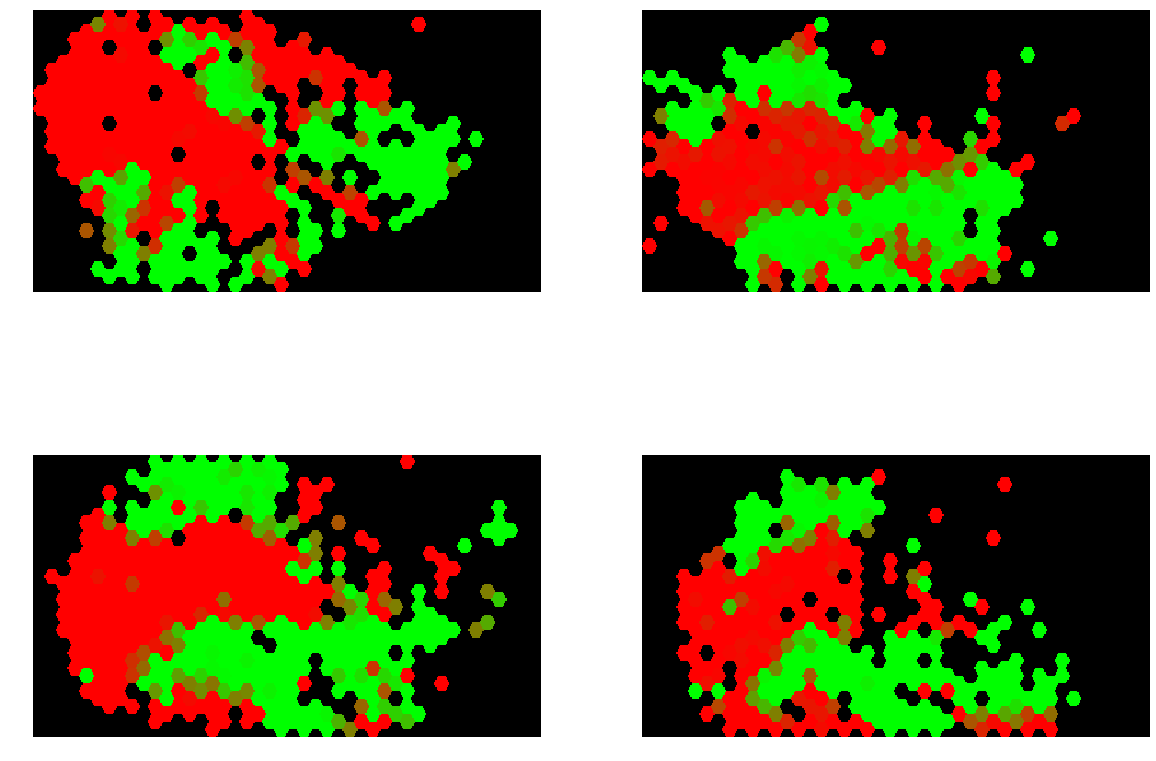

In [429]:
fig, axes = plt.subplots(2,2, figsize=(20,15))
for img, ax in zip(img_list, np.ravel(axes)):
    ax.imshow(img);
    ax.axis('off')

### Analysis 1: Spatial Dependence

I want to show the spatial dependence of the wells: those that are immediate neighbors are likely to contain similar number of hepatocytes/MC38.

In [376]:
segment = counts[['Hepato','MC38']].join(hex_coords['neighbors_1'])

In [377]:
segment['Tot'] = segment[['Hepato','MC38']].sum(axis=1)

In [378]:
with np.errstate(invalid='ignore'):
    segment['Hepato'] = (segment['Hepato'] / segment['Tot']).fillna(0)
    segment['MC38'] = (segment['MC38'] / segment['Tot']).fillna(0)

Here I'm going to correlate the percentage hepatocyte in each well with the mean percentage hepatocyte of its immediate neighbors. I'm only going to consider wells with at least `min_cells` cells and that have at least `min_nonzeros` non-zero immediate neighbors with at least `min_cells_per_neighbor` cells each.

In [374]:
min_cells = 3
min_nonzeros = 2 # max 6 neighbors per well
min_cells_per_neighbor = 3

In [379]:
# doing percent hepato
n_means = list() # means of neighbors
n_vars = list() # variances of neighbors

for i in tqdm(segment.index):
    
    # check if the well in question has at least min_cells
    if segment.loc[i,'Tot'] < min_cells:
        n_means.append(-1)
        n_vars.append(-1)
        continue
    

    # define useful variables
    batch = i[-1]
    n_list = list()
    idxs = list()
    
    for n_i in segment.loc[i, 'neighbors_1']: # for the n_i = index of each neighbor
        idxs.append(tuple(np.append(n_i, batch)))
    
    # subset the segment dataframe
    segment_sub = segment.loc[idxs]
    
    # make a mask for nonzero wells
    nonzero_mask = segment_sub['Tot'] != 0
    
    if nonzero_mask.sum() >= min_nonzeros: # check that we have enough nonzero neighbors
        # only use those neighbors that are nonzero
        segment_sub = segment_sub.loc[nonzero_mask]
        
        # only use those 
        segment_sub = segment_sub[segment_sub['Tot'] > min_cells_per_neighbor]
        if len(segment_sub) == 0:
            # Don't take the mean of an empty slice or variance of a slice of length 1
            # Really only need this when num_nonzeros == 0
            n_means.append(-1)
            n_vars.append(-1)
            continue
        elif len(segment_sub) == 1:
            n_means.append(segment_sub['Hepato'].mean())
            n_vars.append(0)
            continue
        mean = segment_sub['Hepato'].mean()
        var = segment_sub['Hepato'].var()
        n_means.append(mean)
        n_vars.append(var)
    else:
        n_means.append(-1)
        n_vars.append(-1)
        continue

In [380]:
segment['n_means'] = n_means
segment['n_vars'] = n_vars

In [383]:
a = segment[(segment['n_means'] != -1) & # I've marked ones that we don't want to include or that would have produced a NaN as having a mean of -1, so get rid of those
           (segment['Hepato'] != 0) & # we only want mixed wells, so not %Hepatocyte == 0
           (segment['Hepato'] != 1)] # we only want mixed wells, so not %Hepatocyte == 1

In [384]:
a.shape

(352, 6)

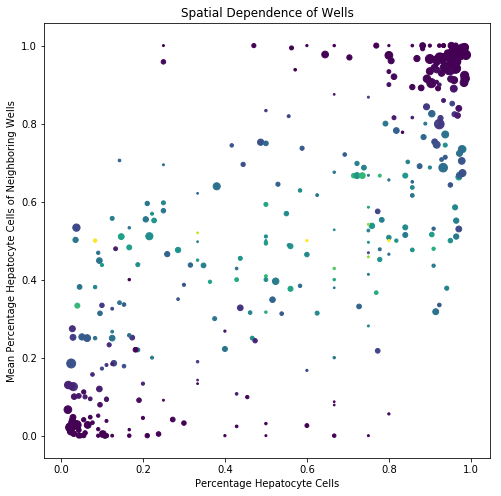

In [386]:
plt.figure(figsize=(8,8))
plt.scatter(a['Hepato'].values, a['n_means'].values, s=a['Tot'], c=a['n_vars'].values);
plt.title('Spatial Dependence of Wells')
plt.xlabel('Percentage Hepatocyte Cells')
plt.ylabel('Mean Percentage Hepatocyte Cells of Neighboring Wells');

In [387]:
a.corr().loc['Hepato','n_means']

0.7684001903735544

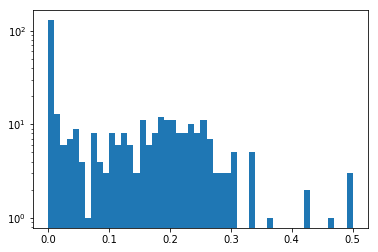

In [388]:
plt.hist(a['n_vars'].values,bins=50);
plt.yscale('log')

I'd like to show that the number of wells with high variance increases towards the center of the distribution (at around 50%).

In [389]:
thresh = 0.05
bin_size = 0.04

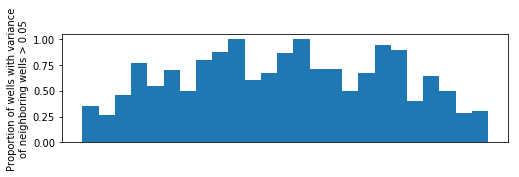

In [390]:
bins = np.arange(0.0, 1 + bin_size, bin_size)
vals = list()
plt.figure(figsize=(8,2))
for i in range(len(bins) - 1):
    a_sub = a[(a['Hepato'] >= bins[i]) & (a['Hepato'] < bins[i+1])]
    vals.append((a_sub['n_vars'] > thresh).sum()/len(a_sub))
plt.bar(bins[:-1] + bin_size/2, vals, width=bin_size);
plt.ylabel('Proportion of wells with variance\nof neighboring wells > %s' % thresh)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

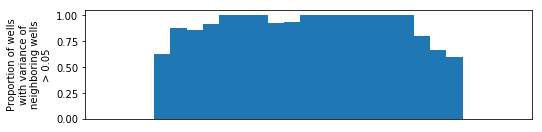

In [391]:
bins = np.arange(0.0, 1 + bin_size, bin_size)
vals = list()
plt.figure(figsize=(8,2))
for i in range(len(bins) - 1):
    a_sub = a[(a['n_means'] >= bins[i]) & (a['n_means'] < bins[i+1])]
    vals.append((a_sub['n_vars'] > thresh).sum()/len(a_sub))
plt.bar(bins[:-1] + bin_size/2, vals, width=bin_size);
plt.ylabel('Proportion of wells\nwith variance of\nneighboring wells\n> %s' % thresh)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

The plot looks like it would fit a logit curve. I will try to fit it to one.

In [392]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

In [393]:
def func(x, a, b):
    return a*(np.log((x/(1-x))) + b)

In [394]:
popt, pcov = curve_fit(func, a['Hepato'].values, a['n_means'].values)

In [395]:
r2_score(a['n_means'].values, np.apply_along_axis(func, 0, a['Hepato'].values, *popt))

0.5998848250100088

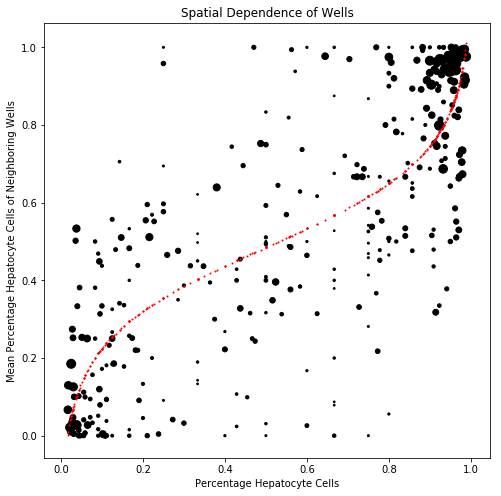

In [397]:
plt.figure(figsize=(8,8))
plt.scatter(a['Hepato'].values, a['n_means'].values, s=a['Tot'], c='k');
plt.scatter(a['Hepato'].values, np.apply_along_axis(func, 0, a['Hepato'].values, *popt), s=1, c='red')
plt.title('Spatial Dependence of Wells')
plt.xlabel('Percentage Hepatocyte Cells')
plt.ylabel('Mean Percentage Hepatocyte Cells of Neighboring Wells');

### Analysis 2: Segmentation Score

The idea here is to use the neighbors to "score" each well as being towards the center of the hepatocyte region or MC38 region. We are curious to see on the UMAP whether or not cells deep in either Hepatocyte or MC38 regions are clustering out separately. 

The first low bar validation of this would be to just show that there is some polarity in UMAP space of the cells when just colored by percent Hepato/MC38. As shown above, many of the wells are either very high or very low percent hepatocyte (and vice versa for MC38), so coloring by this metric would give somewhat of a binary polarity. If that shows something significant in UMAP space, then we can try to parse out internal distance within each region. 

Thinking up a good distance metric is actually more difficult than I originally thought it would be. I've thought about this for what seemed like 30 minutes, just thinking, looking at the images, and I can think of 2 ways in which to determine the metric:
1. Just take the mean % Hepato of all neighbors of order _n_ or lower (i.e. neighbors_1, neighbors_2, ... neighbors\__n_), or perhaps weighted by the order (so like neighbors_1 are weighted more highly than neighbors_4).
2. Base it (somehow) on the average distance of the 3 closest wells of the opposite color (green or red). Only using the distance to the closest green one would be a metric easily skewed by outlier wells (e.g. one green well in a sea a of red). Using 3 or 5 would help smooth out those outliers.

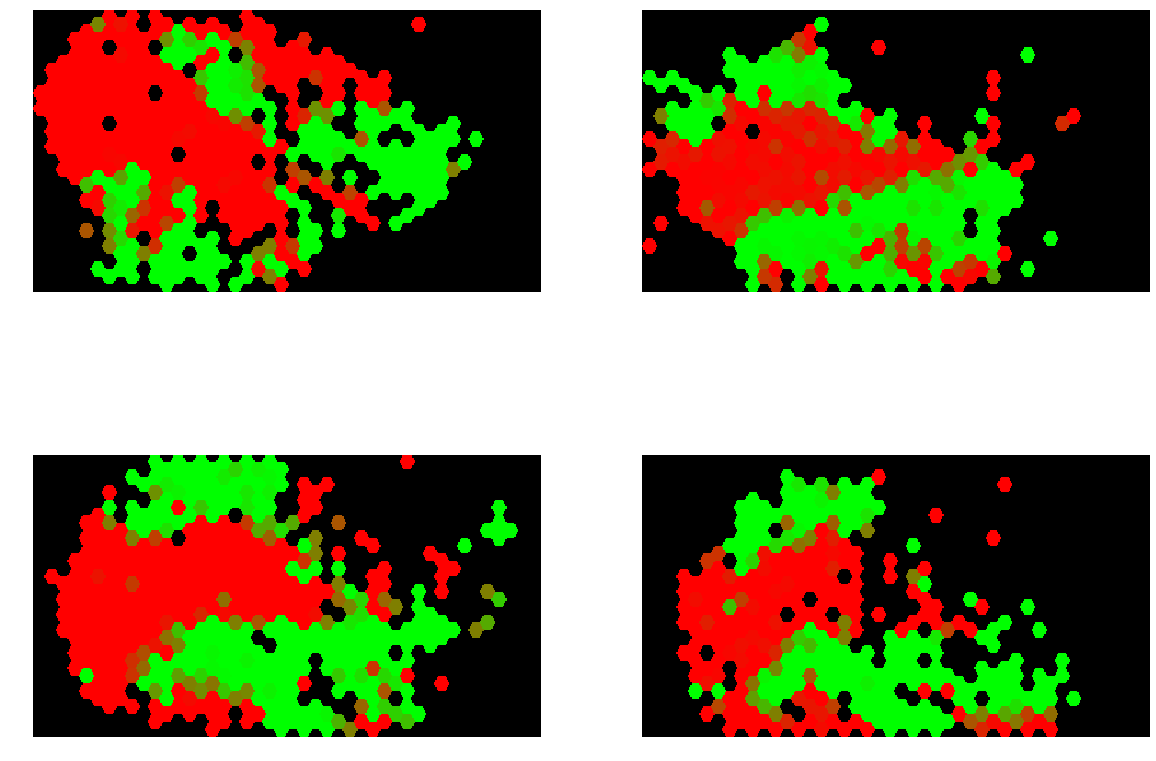

In [430]:
fig, axes = plt.subplots(2,2, figsize=(20,15))
for img, ax in zip(img_list, np.ravel(axes)):
    ax.imshow(img);
    ax.axis('off')

One way to determine the weights. How many levels away you want to go, and a factor to determine the decay.

In [481]:
levels = 5
factor = 2g

In [482]:
denom_factor = sum(list(map(lambda f, l: 1/(f**l),[factor]*levels, range(levels))))

In [483]:
weights = [1/(d*(f**l)) for d, f, l in zip([denom_factor]*levels, 
                                           [factor]*levels, 
                                           range(levels))]

In [484]:
weights

[0.5161290322580645,
 0.25806451612903225,
 0.12903225806451613,
 0.06451612903225806,
 0.03225806451612903]

In [398]:
segment

Hepato  MC38                               neighbors_1  Tot  \
X  Y  batch                                                                
1  1  0         0.0   0.0                          {(1, 2), (2, 1)}    0   
      1         0.0   0.0                          {(1, 2), (2, 1)}    0   
      2         0.0   0.0                          {(1, 2), (2, 1)}    0   
      3         0.0   0.0                          {(1, 2), (2, 1)}    0   
   2  0         0.0   0.0          {(1, 3), (1, 1), (2, 1), (2, 2)}    0   
...             ...   ...                                       ...  ...   
42 17 3         0.0   0.0  {(41, 18), (42, 16), (41, 17), (42, 18)}    0   
   18 0         0.0   0.0                      {(41, 18), (42, 17)}    0   
      1         0.0   0.0                      {(41, 18), (42, 17)}    0   
      2         0.0   0.0                      {(41, 18), (42, 17)}    0   
      3         0.0   0.0                      {(41, 18), (42, 17)}    0   

             n_means  n_vars  
X  Y  batch                   
1  1  0         -1.0    -1.0  
      1         -1.0    -1.0  
      2         -1.0    -1.0  
      3         -1.0    -1.0  
   2  0         -1.0    -1.0  
...              ...     ...  
42 17 3         -1.0    -1.0  
   18 0         -1.0    -1.0  
      1         -1.0    -1.0  
      2         -1.0    -1.0  
      3         -1.0    -1.0  

[3024 rows x 6 columns]

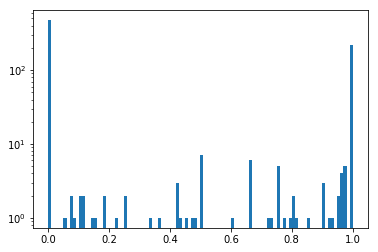

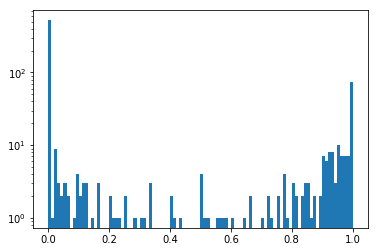

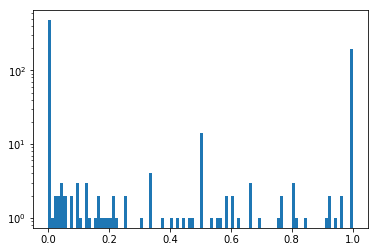

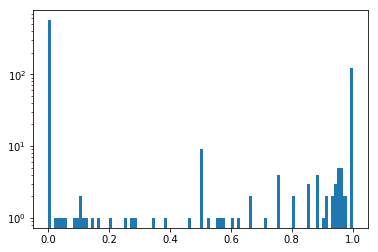

In [424]:
for batch in range(4):
    plt.hist(segment.loc[segment.index.get_level_values('batch') == batch,'Hepato'].values,bins=100)
    plt.yscale('log')
    plt.show()

### 3.2 Method 2

#### Build a Counts DataFrame

This method uses a list of differentially expressed genes between MC38 and Hepatocytes to mark the regions. The benefit of this method is that we now have a much larger set of images to use for alignment.

In [102]:
with open('/myvol/data2/deep2/reg_genes_dict.pkl','rb') as file:
    genes_dict = pkl.load(file)

Make a flat list from the dictionary:

In [103]:
genes = [i for j in list(genes_dict.values()) for i in j]

Confirm that the genes are unique:

In [104]:
print(len(genes))
print(len(np.unique(genes)))

386
386


In [105]:
adata_sub = adata[:,genes].copy()

In [106]:
adata_subs = dict()

In [107]:
batches = adata_sub.obs['batch'].values.unique()

In [108]:
for batch in batches:
    adata_subs[batch] = adata_sub[adata_sub.obs['batch'] == batch].copy()

In [117]:
counts = pd.DataFrame(0,index=pd.MultiIndex.from_product([batches,range(1,43),range(1,19)],names=['batch','X','Y']),columns=genes)

In [118]:
for batch, x, y in tqdm(counts.index):
    xyadata = adata_subs[batch][(adata_subs[batch].obs['X'] == x) & (adata_subs[batch].obs['Y'] == y)].copy()
    for i in range(len(counts.columns)):
        gene = genes[i]
        # try block here is to avoid an index error with obs_vector, it fails when the number of observations is 1
        # at that point, the .X underlying array is a single row by # of genes, so just choose the value as the sum
        try: 
            counts.loc[(batch, x, y),gene] = xyadata.obs_vector(gene).sum()
        except IndexError:
            counts.loc[(batch, x, y),gene] = xyadata.X[i]

This took a while to fill in so I'm going to dump it into a pkl.

In [119]:
# with open('/myvol/data2/deep2/counts.pkl', 'wb') as file:
#     pkl.dump(counts,file)
with open('/myvol/data2/deep2/counts.pkl', 'rb') as file:
    counts = pkl.load(file)

#### Fill in the Hexarray with Color Values

In [120]:
def get_colors(s):
    '''
    So this function I found is a nice way to divide up the bimodal distribution of the pixel values generated from gene values.
    Block 1 generates a distribution where a huge mode gets generated right at the where the negative distribution ends.
    Block 2 finds where that mode and clips anything below it to zero, then rescales to 255.
    Together, they produce a nice distribution that matches the histology slides.
    '''
    # Block 1
    colors = s.values
    colors = (colors - colors.min())
    colors /= colors.max()
    colors *= 255
    
    # Block 2
    n, bins, patches = plt.hist(colors,bins=256);
    plt.close()
    offset = bins[n.argmax()+1]
    colors -= offset
    colors = np.clip(colors,0,colors.max())
    colors /= colors.max()
    colors *= 255
    
    s = pd.Series(colors,index=s.index,name='color')
    s = s[s!=0].copy()
    
    return s

In [121]:
def get_image(colors):
    '''
    df is a dataframe with multiindex of names X and Y, and a single column containing the counts of the genes in each well
    '''
    
    df = hex_coords.join(colors)
    df.dropna(inplace=True) # I would convert nans to zeros anyways, and my array is going to be initialized with zeros anyway
    
    img = np.zeros((222,399)) # this was the calculated size of my 12 pixel hexagons perfectly stacked
    
    for i in df.index:
        hex_ystart = int(df.loc[i,'hex_ystart'])
        hex_yend = hex_ystart + 12

        hex_xstart = int(df.loc[i,'hex_xstart'])
        hex_xend = hex_xstart + 12
        
        current_hex = img[hex_ystart:hex_yend,hex_xstart:hex_xend]
        img[hex_ystart:hex_yend, hex_xstart:hex_xend] = np.where(myhex, df.loc[i,'color'], current_hex)
    return img

In [145]:
images_list = list()
for batch in tqdm(counts.index.get_level_values('batch').unique()):
    images = list()
    for gene in tqdm(counts.loc[batch].columns):
        colors = get_colors(counts.loc[batch, gene])
        img = get_image(colors)
        images.append(img) # make the nans zeros

    # using an array of csr_matrices will save a ton of memory, since these images are zero inflated
    images_list.append(np.array(list(map(csr_matrix,images))))

This took a while to build so I'm going to dump it into a pkl. I will do analysis in a separate notebook.

In [146]:
with open('/myvol/data2/deep2/images.pkl', 'wb') as file:
    pkl.dump(images_list,file)